Question 1: Outliers Removal and Transformation

In [87]:
import pandas as pd
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import joblib

In [6]:
#1.1
df = pd.read_csv('stroke_data.csv')

glucose = df['avg_glucose_level'].dropna()

skew_val = skew(glucose)
kurt_val = kurtosis(glucose)
print(skew_val)
print(kurt_val)

1.573103476107217
1.6832979725142145


In [8]:
#1.2
df_filtered = df[df['bmi'].notna()].copy()

print('original dataframe shape: ', df.shape)
print('filtered dataframe shape (without NaN in bmi): ', df_filtered.shape)

original dataframe shape:  (5117, 12)
filtered dataframe shape (without NaN in bmi):  (4915, 12)


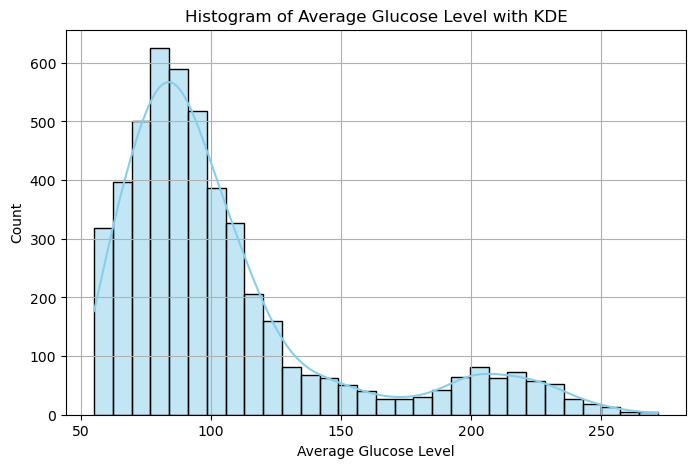

In [12]:
#1.3
plt.figure(figsize = (8,5))
sns.histplot(df_filtered['avg_glucose_level'], kde=True, bins=30, color='skyblue')

plt.xlabel('Average Glucose Level')
plt.ylabel('Count')
plt.title('Histogram of Average Glucose Level with KDE')
plt.grid(True)
plt.show()

Q1 = 77.05, Q3 = 113.46, IQR = 36.41
Lower bound = 22.44, Upper bound = 168.07


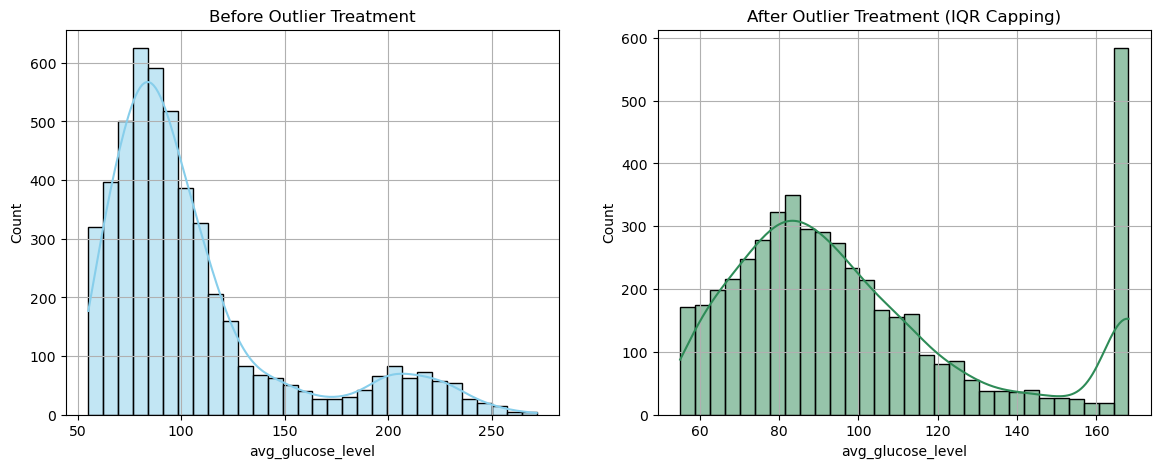

In [93]:
#1.4
Q1 = df_filtered['avg_glucose_level'].quantile(0.25)
Q3 = df_filtered['avg_glucose_level'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f'Q1 = {Q1:.2f}, Q3 = {Q3:.2f}, IQR = {IQR:.2f}')
print(f'Lower bound = {lower_bound:.2f}, Upper bound = {upper_bound:.2f}')

glucose_capped = df_filtered['avg_glucose_level'].clip(lower = lower_bound, upper = upper_bound)

plt.figure(figsize = (14,5))

plt.subplot(1,2,1)
sns.histplot(df_filtered['avg_glucose_level'], kde=True, bins=30, color='skyblue')
plt.title('Before Outlier Treatment')
plt.grid(True)

plt.subplot(1,2,2)
sns.histplot(glucose_capped, kde=True, bins=30, color='seagreen')
plt.title('After Outlier Treatment (IQR Capping)')
plt.grid(True)

plt.show()

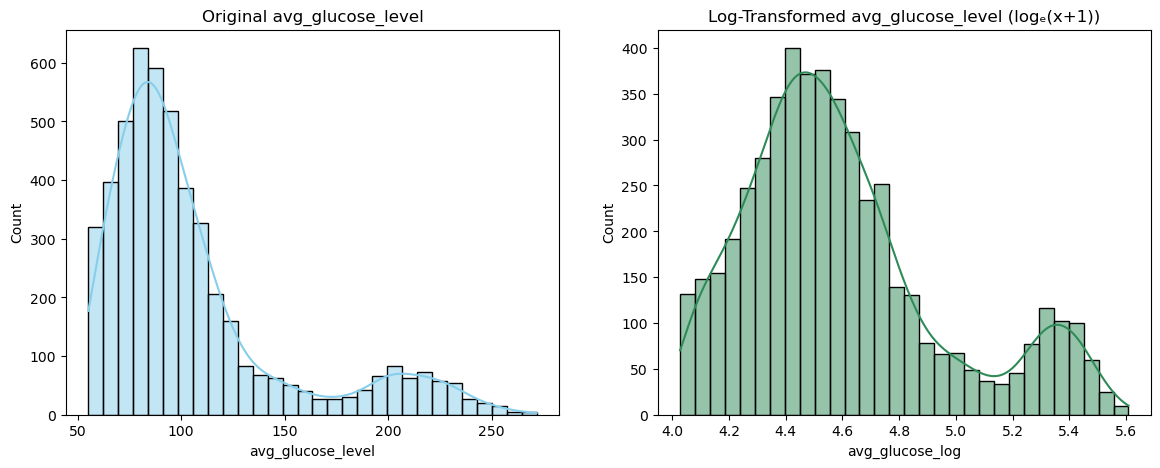

In [33]:
#1.5
df_filtered['avg_glucose_log'] = np.log1p(df_filtered['avg_glucose_level'])

plt.figure(figsize = (14,5))

plt.subplot(1,2,1)
sns.histplot(df_filtered['avg_glucose_level'], kde=True, bins=30, color='skyblue')
plt.title('Original avg_glucose_level')

plt.subplot(1,2,2)
sns.histplot(df_filtered['avg_glucose_log'], kde=True, bins=30, color='seagreen')
plt.title('Log-Transformed avg_glucose_level (logₑ(x+1))')

plt.show()

In [35]:
#1.6
glucose_log = df_filtered['avg_glucose_log'].dropna()

skew_val_log = skew(glucose_log)
kurt_val_log = kurtosis(glucose_log)

print(f'Skewness (log_transformed): {skew_val_log:.4f}')
print(f'Kurtosis (log_transformed): {kurt_val_log:.4f}')

Skewness (log_transformed): 0.8993
Kurtosis (log_transformed): 0.2423


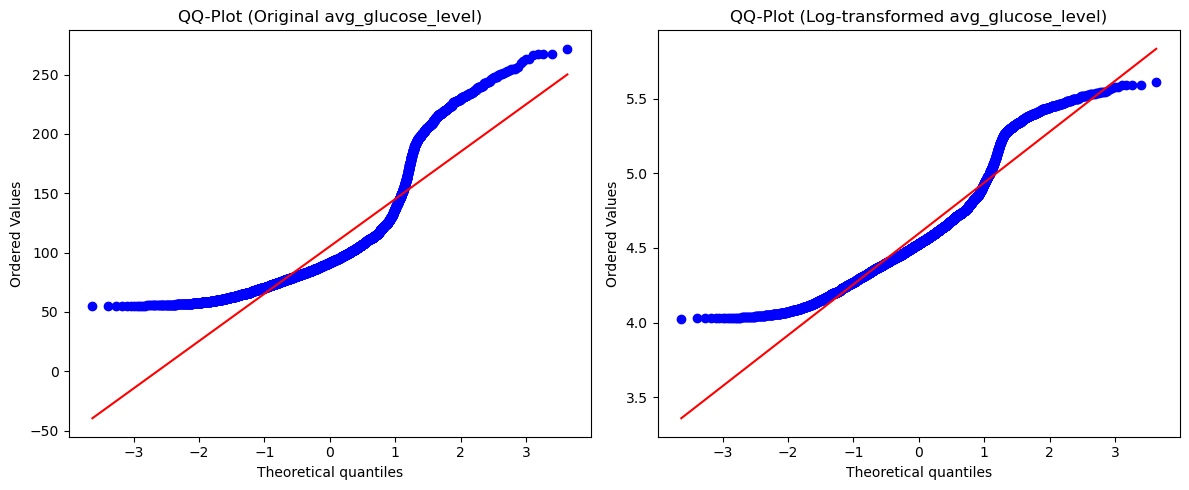

In [37]:
#1.7
plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
stats.probplot(df_filtered['avg_glucose_level'], dist='norm', plot=plt)
plt.title('QQ-Plot (Original avg_glucose_level)')

plt.subplot(1,2,2)
stats.probplot(df_filtered['avg_glucose_log'], dist='norm', plot=plt)
plt.title('QQ-Plot (Log-transformed avg_glucose_level)')

plt.tight_layout()
plt.show()

BMI: Q1=23.50, Q3=33.10, Lower=9.10, Upper=47.50
Age: Q1=25.00, Q3=60.00, Lower=-27.50, Upper=112.50


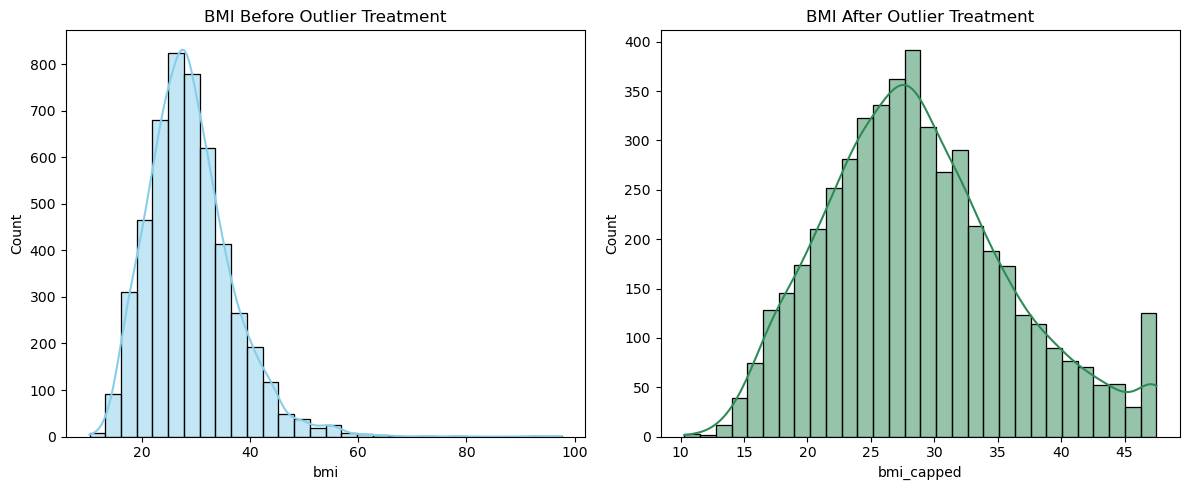

In [39]:
#1.8
def iqr_cap(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.clip(lower, upper), (Q1, Q3, lower, upper)

df_filtered['bmi_capped'], bmi_stats = iqr_cap(df_filtered['bmi'])
print(f'BMI: Q1={bmi_stats[0]:.2f}, Q3={bmi_stats[1]:.2f}, '
      f'Lower={bmi_stats[2]:.2f}, Upper={bmi_stats[3]:.2f}')

df_filtered['age_capped'], age_stats = iqr_cap(df_filtered['age'])
print(f'Age: Q1={age_stats[0]:.2f}, Q3={age_stats[1]:.2f}, '
      f'Lower={age_stats[2]:.2f}, Upper={age_stats[3]:.2f}')

plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
sns.histplot(df_filtered['bmi'], kde=True, bins=30, color='skyblue')
plt.title('BMI Before Outlier Treatment')

plt.subplot(1,2,2)
sns.histplot(df_filtered['bmi_capped'], kde=True, bins=30, color='seagreen')
plt.title('BMI After Outlier Treatment')

plt.tight_layout()
plt.show()

      

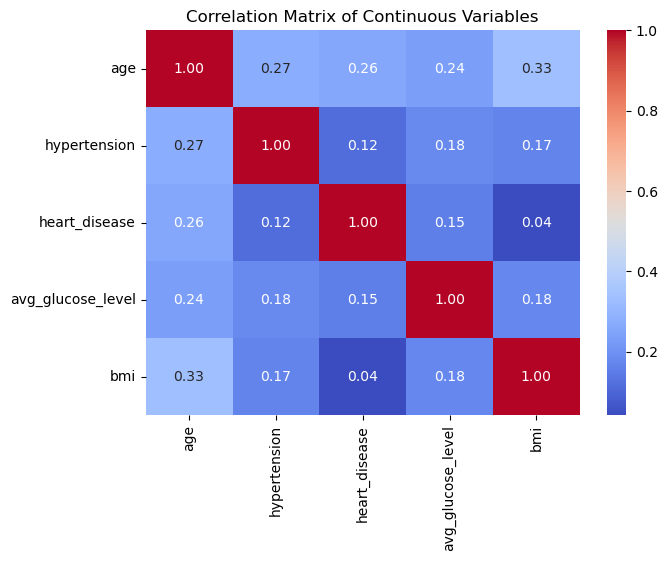

In [41]:
#1.9
cont_vars = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
corr_matrix = df_filtered[cont_vars].corr()

plt.figure(figsize = (7,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)

plt.title('Correlation Matrix of Continuous Variables')
plt.show()

Question 2: Data Processing

In [43]:
#2.1
work_bmi = df_filtered.groupby('work_type')['bmi'].mean().reset_index()
print(work_bmi)

       work_type        bmi
0       Govt_job  30.522063
1   Never_worked  25.545455
2        Private  30.293321
3  Self-employed  30.206950
4       children  20.038003


In [51]:
#2.2
smoke_stats = df_filtered.groupby('smoking_status').agg(
    avg_age = ('age', 'mean'),
    avg_glucose = ('avg_glucose_level', 'mean'),
    stroke_cases = ('stroke', 'sum'),
    total_patients = ('stroke', 'size')
).reset_index()

print(smoke_stats)

    smoking_status    avg_age  avg_glucose  stroke_cases  total_patients
0          Unknown  29.508156    98.255323            29            1486
1  formerly smoked  54.957092   112.510620            57             839
2     never smoked  46.469222   107.136215            84            1852
3           smokes  47.008130   106.436612            39             738


In [53]:
#2.3
df_filtered['glucose_bmi_ratio'] = df_filtered['avg_glucose_level'] / df_filtered['bmi']
print(df_filtered[['avg_glucose_level', 'bmi', 'glucose_bmi_ratio']].head())

   avg_glucose_level   bmi  glucose_bmi_ratio
1             228.69  36.6           6.248361
3             105.92  32.5           3.259077
4             171.23  34.4           4.977616
5             174.12  24.0           7.255000
6             186.21  29.0           6.421034


In [67]:
#2.4
conditions = [
    (df_filtered['age'] > 65) & ((df_filtered['hypertension'] == 1) | (df_filtered['heart_disease'] == 1)),
    (df_filtered['age'] > 50) & (df_filtered['avg_glucose_level'] > 200),
    (df_filtered['age'] > 40) & ((df_filtered['age'] <= 50)) | (df_filtered['avg_glucose_level'] > 140)
]

choices = ['Very High', 'High', 'Medium']

df_filtered['risk_category'] = np.select(conditions, choices, default='Low')

print(df_filtered[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'risk_category']].head(10))

     age  hypertension  heart_disease  avg_glucose_level risk_category
1   67.0             0              1             228.69     Very High
3   80.0             0              1             105.92     Very High
4   49.0             0              0             171.23        Medium
5   79.0             1              0             174.12     Very High
6   81.0             0              0             186.21        Medium
7   74.0             1              1              70.09     Very High
8   69.0             0              0              94.39           Low
10  78.0             0              0              58.57           Low
11  81.0             1              0              80.43     Very High
12  61.0             0              1             120.46           Low


In [79]:
#2.5
age_groups = pd.read_csv('age_groups.csv')

df_filtered['age_int'] = df_filtered['age'].round().astype(int)

age_groups['age'] = age_groups['age'].astype(int)

df_merged = pd.merge(
    df_filtered,
    age_groups,
    how = 'left',
    left_on = 'age_int',
    right_on = 'age'
)

df_merged = df_merged.rename(columns={'age_x': 'age'}).drop(columns=['age_y'])

print(df_merged[['age', 'age_category']].head(10))

    age age_category
0  67.0       Senior
1  80.0       Senior
2  49.0        Adult
3  79.0       Senior
4  81.0       Senior
5  74.0       Senior
6  69.0       Senior
7  78.0       Senior
8  81.0       Senior
9  61.0   Middle Age


In [83]:
#2.6
df_encoded = pd.get_dummies(df_merged, columns = ['smoking_status', 'work_type'], drop_first=False)

print(df_encoded.filter(like='smoking_status').head())
print(df_encoded.filter(like='work_type').head())

print('Final shape:', df_encoded.shape)

   smoking_status_Unknown  smoking_status_formerly smoked  \
0                   False                            True   
1                   False                           False   
2                   False                           False   
3                   False                           False   
4                   False                            True   

   smoking_status_never smoked  smoking_status_smokes  
0                        False                  False  
1                         True                  False  
2                        False                   True  
3                         True                  False  
4                        False                  False  
   work_type_Govt_job  work_type_Never_worked  work_type_Private  \
0               False                   False               True   
1               False                   False               True   
2               False                   False               True   
3               False    

In [85]:
#2.7
df_encoded['is_elderly'] = (df_encoded['age'] >= 60).astype(int)

print(df_encoded[['age', 'is_elderly']].head(10))

    age  is_elderly
0  67.0           1
1  80.0           1
2  49.0           0
3  79.0           1
4  81.0           1
5  74.0           1
6  69.0           1
7  78.0           1
8  81.0           1
9  61.0           1


In [89]:
#2.8
scaler = StandardScaler()

df_encoded[['bmi_scaled', 'avg_glucose_scaled']] = scaler.fit_transform(
    df_encoded[['bmi', 'avg_glucose_level']]
)

joblib.dump(scaler, 'scaler.pkl')

print(df_encoded[['bmi', 'bmi_scaled', 'avg_glucose_level', 'avg_glucose_scaled']].head())

    bmi  bmi_scaled  avg_glucose_level  avg_glucose_scaled
0  36.6    0.982340             228.69            2.779193
1  32.5    0.460112             105.92            0.014781
2  34.4    0.702120             171.23            1.485366
3  24.0   -0.622555             174.12            1.550440
4  29.0    0.014308             186.21            1.822671
